<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Exercises for the course<br>
        <b>Machine Learning for Data Science</b><br>
    Winter Semester 2024/25
    </p>
</td>
<td style='background-color:white'>
    G. Montavon<br>
    Institute of Computer Science<br>
    <b>Department of Mathematics and Computer Science</b><br>
    Freie Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 6 (programming part)</h1>
</center>
<br>

In this exercise, we consider canonical correlation analysis (CCA) on two simple problems, one in low dimensions and one in high dimensions. The goal is to implement the original CCA procedure, and the CCA variant for high-dimensional data, in order to handle both cases. The first dataset consists of two trajectories in two dimensions. The dataset is extracted and plotted below. The first data points are shown in dark blue, and the last ones are shown in yellow.

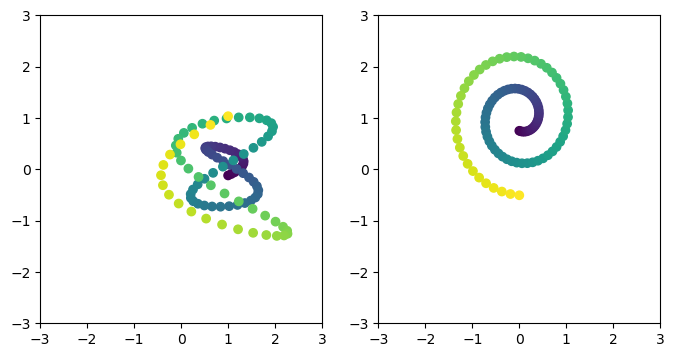

In [1]:
import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import utils

X,Y   = utils.getdata()
p1,p2 = utils.plotdata(X,Y)

For these two trajetories, that can be understood as two different modalities of the same data, we would like determine under which projections they appear maximally correlated.

## Exercise 3: Implementing CCA (25 P)

As stated in the lecture, the CCA problem in its original form consists of maximizing the cross-correlation objective:

$$J(w_x,w_y) =  w_x^\top C_{xy} w_y$$

subject to autocorrelation constraints $w_x^\top C_{xx} w_x = 1$ and $w_y^\top C_{yy} w_y = 1$. Using the method of Lagrange multipliers, this optimization problem can be reduced to finding the first eigenvector of the generalized eigenvalue problem:

$$
\begin{bmatrix}0 & C_{xy}\\C_{yx} & 0\end{bmatrix}
\begin{bmatrix}w_x\\w_y\end{bmatrix} =
\lambda
\begin{bmatrix}C_{xx} & 0\\0 & C_{yy}\end{bmatrix}
\begin{bmatrix}w_x\\w_y\end{bmatrix} 
$$

Your first task is to write a function that solves this generalized eigenvalue problem. The function you need to implement receives two matrices `X` and `Y` of size `d1` $\times$ `N` and  `d2` $\times$ `N` respectively. It should return two vectors of size `d1` and `d2` corresponding to the projections associated to the modalities `X` and `Y`. *(Hint: Note that the data matrices `X` and `Y` have not been centered yet.)*

In [2]:
import numpy as np

def CCA(X, Y):
    # Center the data
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    Y_centered = Y - np.mean(Y, axis=1, keepdims=True)
    
    # Covariance matrices
    C_xx = np.cov(X_centered)
    C_yy = np.cov(Y_centered)
    C_xy = np.cov(X_centered, Y_centered)[:X.shape[0], X.shape[0]:]
    
    # Form the generalized eigenvalue problem matrix
    C = np.block([[np.zeros_like(C_xx), C_xy], 
                  [C_xy.T, np.zeros_like(C_yy)]])
    D = np.block([[C_xx, np.zeros_like(C_xy)], 
                  [np.zeros_like(C_xy.T), C_yy]])
    
    # Solve the generalized eigenvalue problem
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(D) @ C)
    
    # Extract the first eigenvector (corresponding to the largest eigenvalue)
    idx = np.argmax(eigvals)
    w = eigvecs[:, idx]
    
    # Separate the eigenvector into projections for X and Y
    wx = w[:X.shape[0]]
    wy = w[X.shape[0]:]
    
    return wx, wy

The function can now be called with our dataset. The learned projection vectors $w_x$ and $w_y$ are plotted as red arrows.

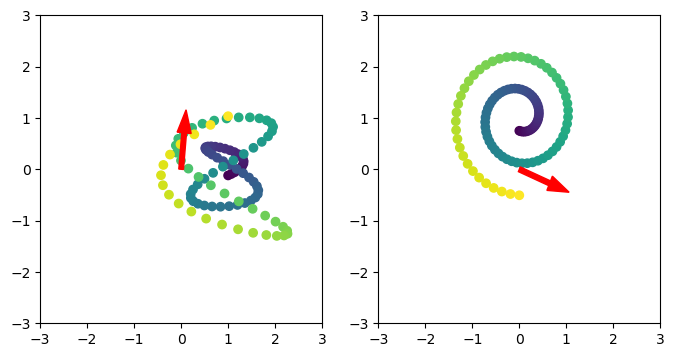

In [3]:
wx,wy = CCA(X,Y)

p1,p2 = utils.plotdata(X,Y)
p1.arrow(0,0,1*wx[0],1*wx[1],color='red',width=0.1)
p2.arrow(0,0,1*wy[0],1*wy[1],color='red',width=0.1)
plt.show()

In each modality, the arrow points in a specific direction (note that the optimal CCA directions are defined up to a sign flip of both $w_x$ and $w_y$). Furthermore, we can verify CCA has learned a meaningful solution by projecting the data on it.

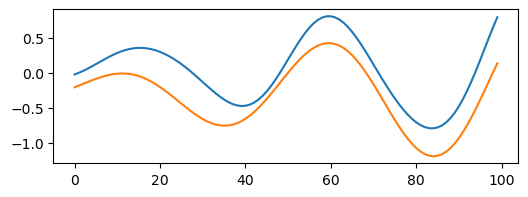

In [4]:
plt.figure(figsize=(6,2))
plt.plot(wx.dot(X))
plt.plot(wy.dot(Y))
plt.show()

Clearly, the data is correlated in the projected space.

## Exercise 4: Implementing CCA for High Dimensions (25 P)

In the second part of the exercise, we consider the case where the data is high dimensional (with `d` $\gg$ `N`). Such high-dimensionality occurs for example, when input data are images. We consider the scenario where sources emit spatially, and two (noisy) receivers measure the spatial field at different locations. We would like to identify the signal that is common to the two measured locations, e.g. a given source emitting at a given frequency. We first load the data and show one example.

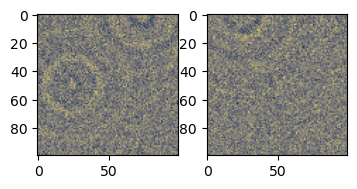

In [5]:
X,Y = utils.getHDdata()

utils.plotHDdata(X[:,0],Y[:,0])
plt.show()

Several sources can be perceived, however, there is a significant level of noise. Here again, we will use CCA to find subspaces where the two modalities are maximally correlated. In this example, because there are many more dimensions than there are data points, it is more advantageous to solve the alternate formulation of CCA in terms of the weightings $\alpha_x$ and $\alpha_y$. Your task is to implement the latter CCA solver. Like the original CCA solver, it receives two data matrices of size `d1` $\times$ `N` and `d2` $\times$ `N` respectively as input, and should return the associate CCA directions (two vectors of respective sizes `d1` and `d2`).

In [6]:
import numpy as np
from utils import getHDdata, plotHDdata

def CCA_HD(X, Y):
    """
    Canonical Correlation Analysis for high-dimensional data.
    Optimized for d >> N.
    """
    # Center the data
    X_centered = X - np.mean(X, axis=0, keepdims=True)
    Y_centered = Y - np.mean(Y, axis=0, keepdims=True)
    
    # Perform SVD on X_centered and Y_centered to reduce dimensionality
    U_x, S_x, V_x = np.linalg.svd(X_centered, full_matrices=False)
    U_y, S_y, V_y = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Reduce the data to the span of the largest singular vectors
    X_reduced = np.diag(S_x) @ V_x
    Y_reduced = np.diag(S_y) @ V_y
    
    # Compute the cross-covariance matrix in the reduced space
    C_xy = X_reduced @ Y_reduced.T / (X.shape[0] - 1)
    
    # Solve the eigenvalue problem in the reduced space
    U, S, V = np.linalg.svd(C_xy)
    
    # The top singular vector corresponds to the optimal directions
    alpha_x = U[:, 0]
    alpha_y = V[0, :]
    
    # Convert alpha_x and alpha_y back to original dimensions
    wx = U_x @ alpha_x
    wy = U_y @ alpha_y
    
    return wx, wy

We now call the function we have implemented with a training sequence of 100 pairs of images. Because the returned solution is of same dimensions as the inputs, it can be rendered in a similar fashion.

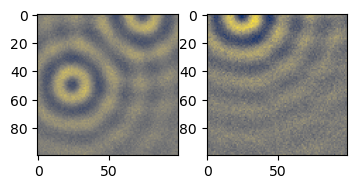

In [7]:
wx,wy = CCA_HD(X,Y)

utils.plotHDdata(wx,wy)
plt.show()

Here, we can clearly see a common factor that has been extracted between the two fields, specifically a point source emitting at a particular frequency. The sequence of image pairs can now be projected on these two filters:

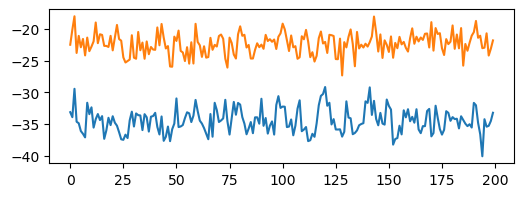

In [8]:
plt.figure(figsize=(6,2))
plt.plot(wx.dot(X))
plt.plot(wy.dot(Y))
plt.show()